In [1]:
import scanpy as sc
import numpy as np
import random
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100)
random.seed(66)

data_path = "E:/Projection-seq/UPB_Full/"
sample_ID = "Barcode-1"

adata = sc.read_10x_h5(data_path + sample_ID + "/outs/filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata.obs["sample_id"] = [sample_ID] * adata.n_obs
adata

reading E:/Projection-seq/UPB_Full/Barcode-1/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4693 × 30648
    obs: 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'

In [2]:
transgenes = ["UPB1", "UPB2", "UPB4", "UPB6"] # , "WPRE", "tdTomato", "GCaMP"

for g in transgenes:
    adata.obs.loc[:, g] = adata[:, g].X.toarray().astype(int)

genes = [g for g in adata.var_names if g not in transgenes]
adata = adata[:, genes]

In [3]:
adata.obs["UPBs"] = [None] * adata.shape[0]

upb_combos = ["1", "2", "4", "6", "1-2", "1-4", "1-6", "2-4", "2-6", "4-6", "1-2-4", "1-2-6", "2-4-6"]

for combo in upb_combos:
    cols = ["UPB" + dg for dg in combo.split("-")]
    mask = np.sum(adata.obs[cols] > 0, axis=1) == len(cols)
    adata.obs.loc[mask, "UPBs"] = combo

C:\Users\TLab\AppData\Local\Temp\ipykernel_8448\3602422971.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["UPBs"] = [None] * adata.shape[0]


In [4]:
adata.obs["LM"] = np.sum(adata.obs[["UPB1", "UPB4"]], axis=1) > 0
adata.obs["RL"] = np.sum(adata.obs[["UPB2", "UPB6"]], axis=1) > 0

In [6]:
adata.obs["VISs"] = [None] * adata.shape[0]

vis_combos = ["LM", "RL", "LM-RL"]

for combo in vis_combos:
    cols = combo.split("-")
    mask = np.sum(adata.obs[cols] == True, axis=1) == len(cols)
    adata.obs.loc[mask, "VISs"] = combo

In [7]:
sc.pp.filter_cells(adata, min_genes=700)
sc.pp.filter_genes(adata, min_cells=8)

filtered out 141 cells that have less than 700 genes expressed
filtered out 11170 genes that are detected in less than 8 cells


In [8]:
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = 100 * (np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))

In [9]:
adata.obs["n_UMIs"] = np.sum(adata.X, axis=1).astype(int)

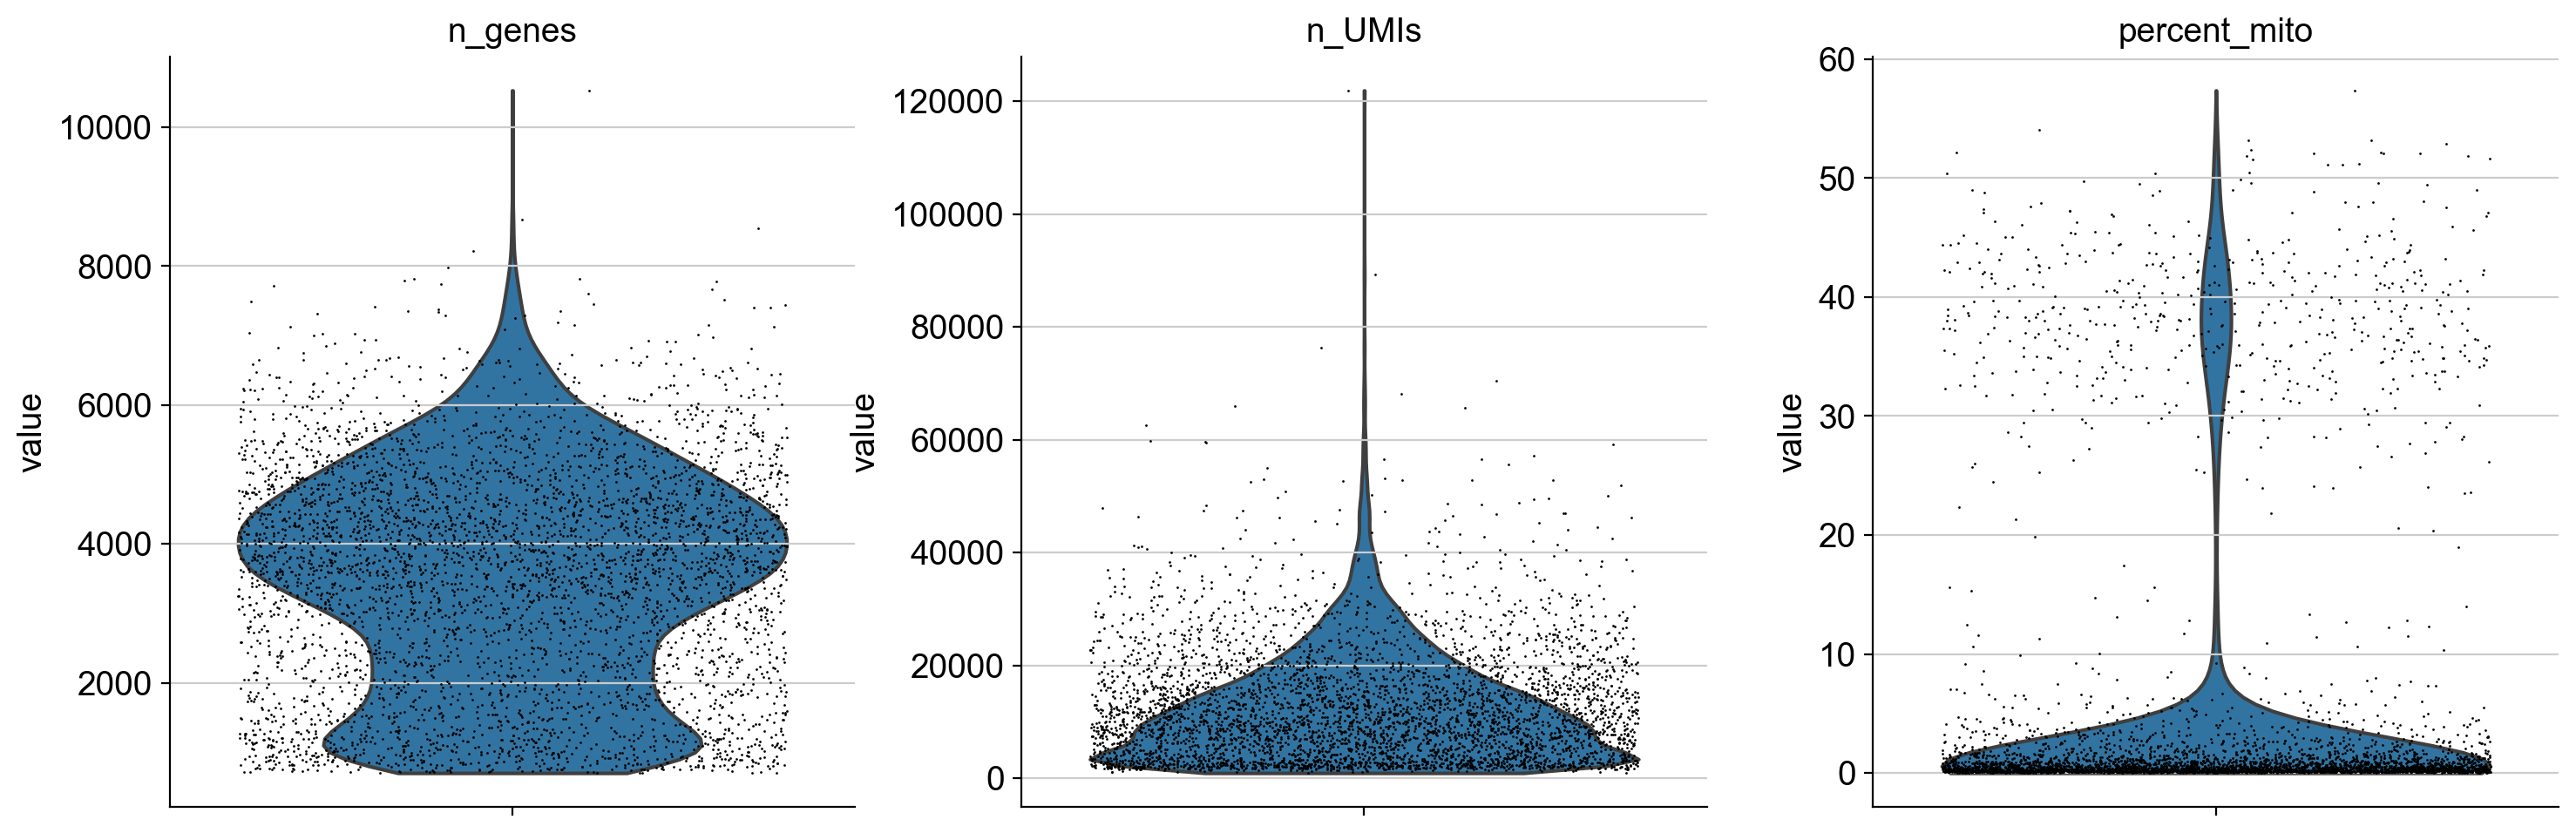

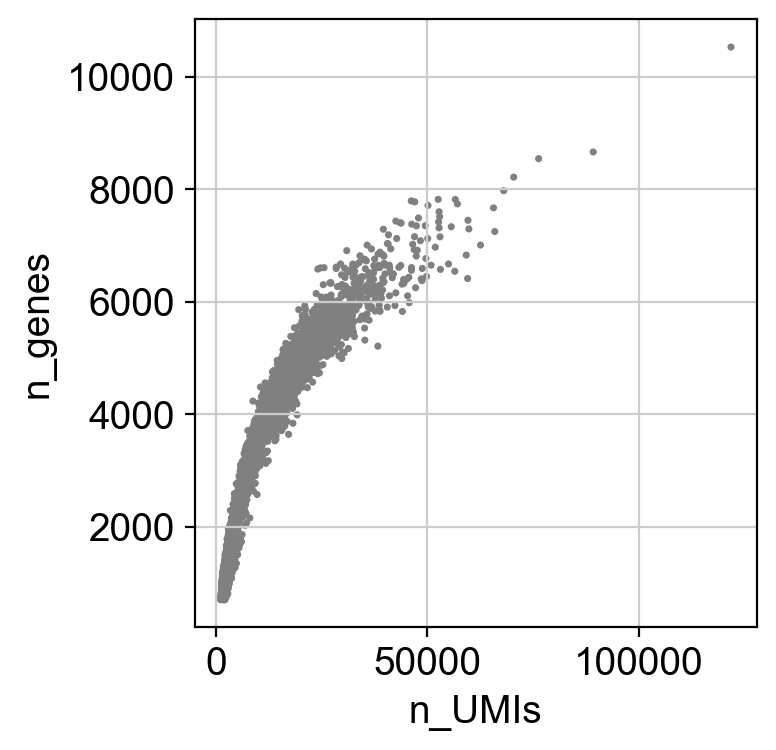

In [10]:
sc.pl.violin(adata, ["n_genes", "n_UMIs", "percent_mito"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_UMIs', y='n_genes')

In [11]:
adata = adata[adata.obs["percent_mito"] < 1, :]
adata = adata[adata.obs["n_genes"] < 6500, :]
adata = adata[adata.obs["n_UMIs"] < 40000, :]

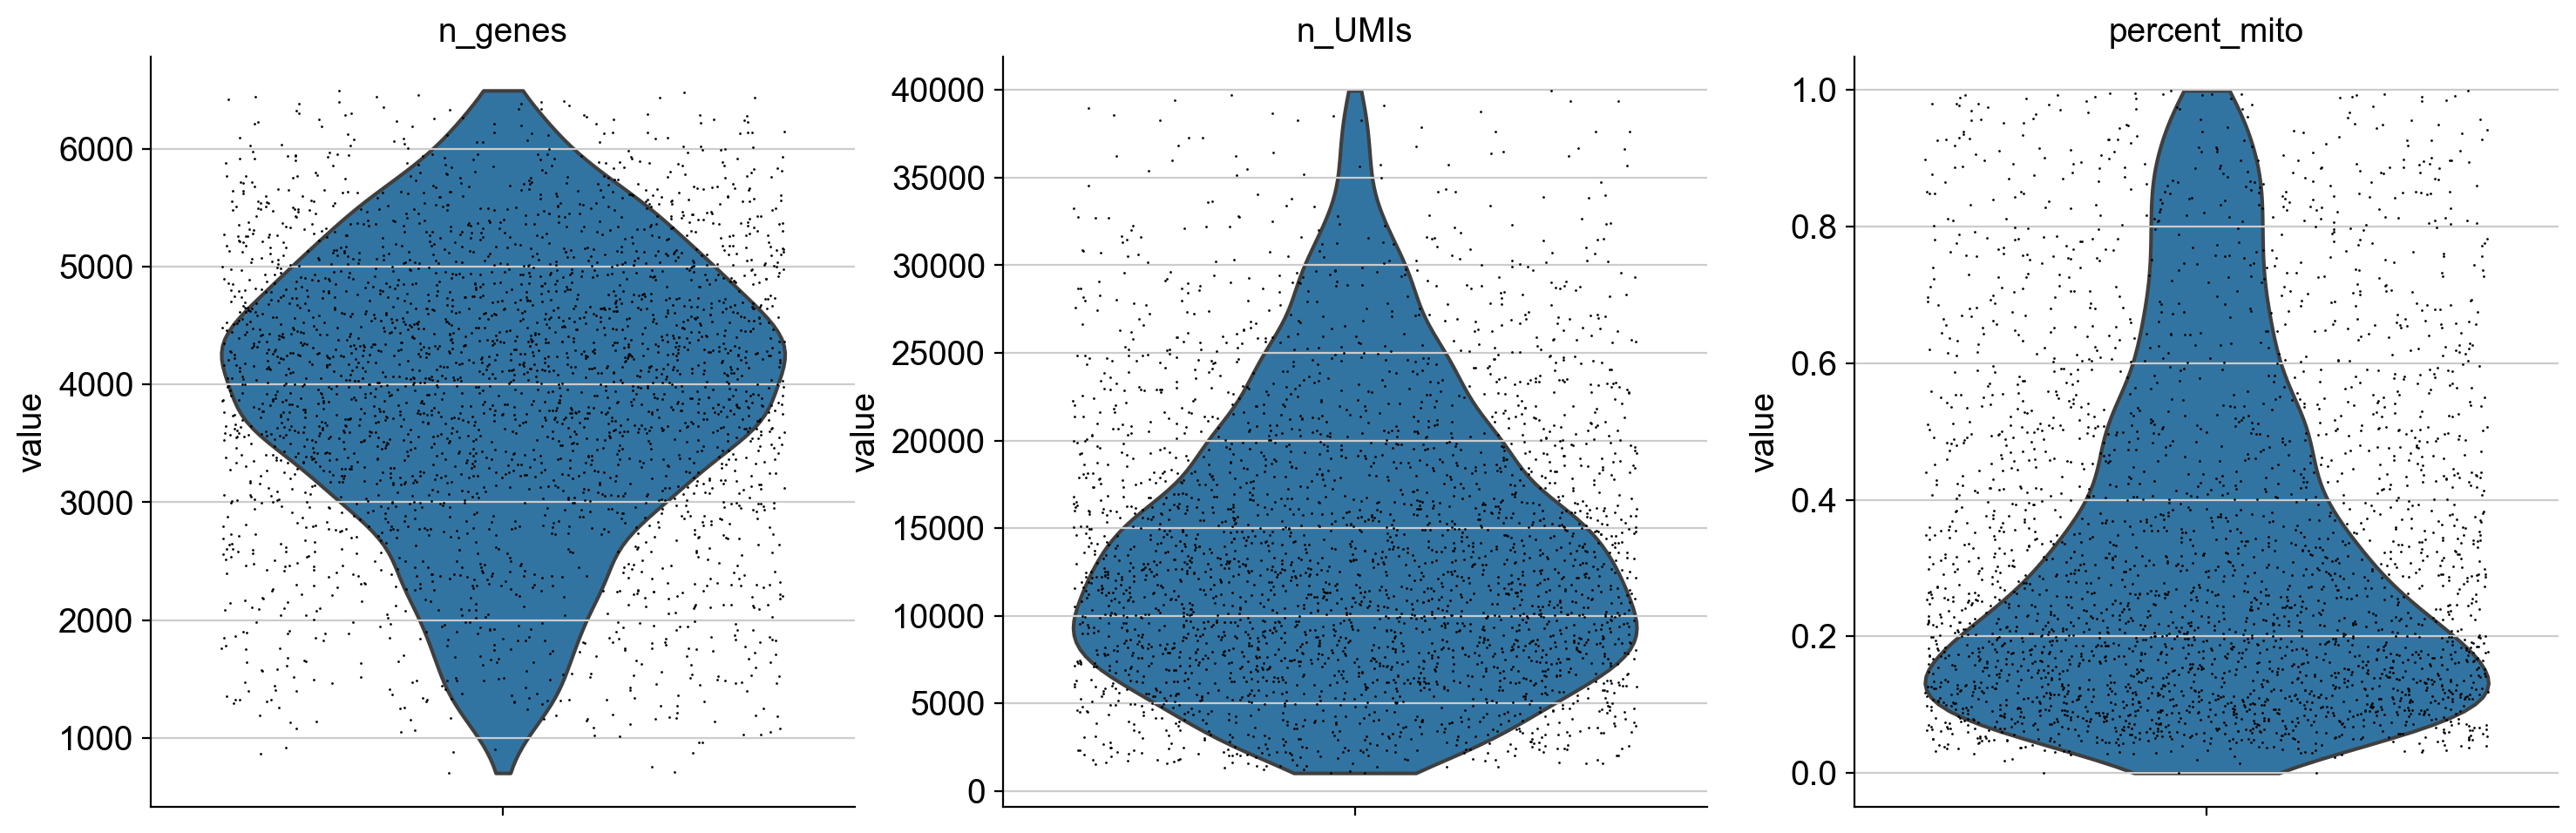

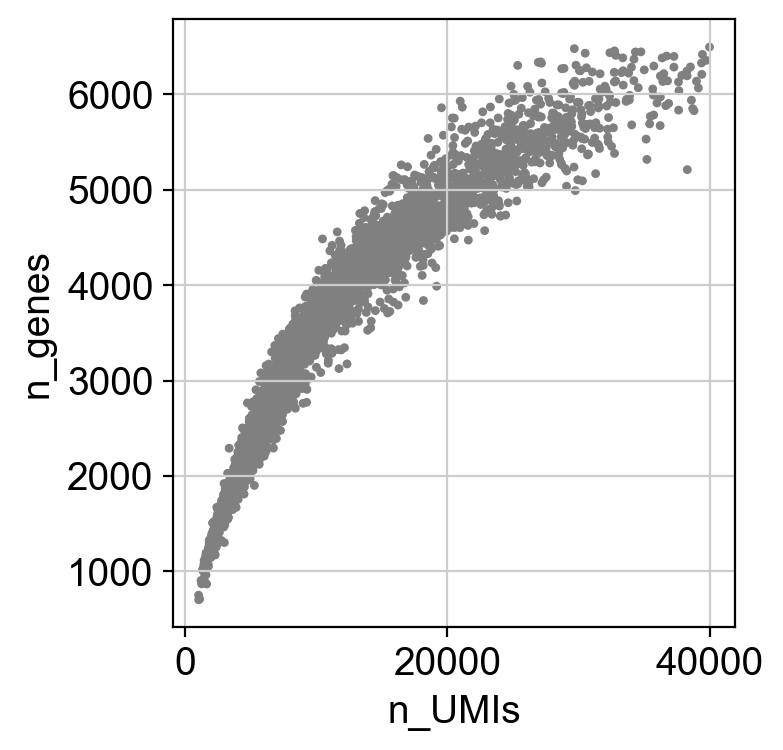

In [12]:
sc.pl.violin(adata, ["n_genes", "n_UMIs", "percent_mito"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="n_UMIs", y="n_genes")

In [13]:
import scrublet as scr

counts_matrix = adata.X
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)

doublet_scores, predicted_doublets = scrub.scrub_doublets(min_cells=8, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=40)

adata.obs["doublet"] = scrub.predicted_doublets_
adata.obs["doublet_score"] = scrub.doublet_scores_obs_

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 46.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.9%
Elapsed time: 4.3 seconds


C:\Users\TLab\AppData\Local\Temp\ipykernel_8448\1727709204.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet"] = scrub.predicted_doublets_


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

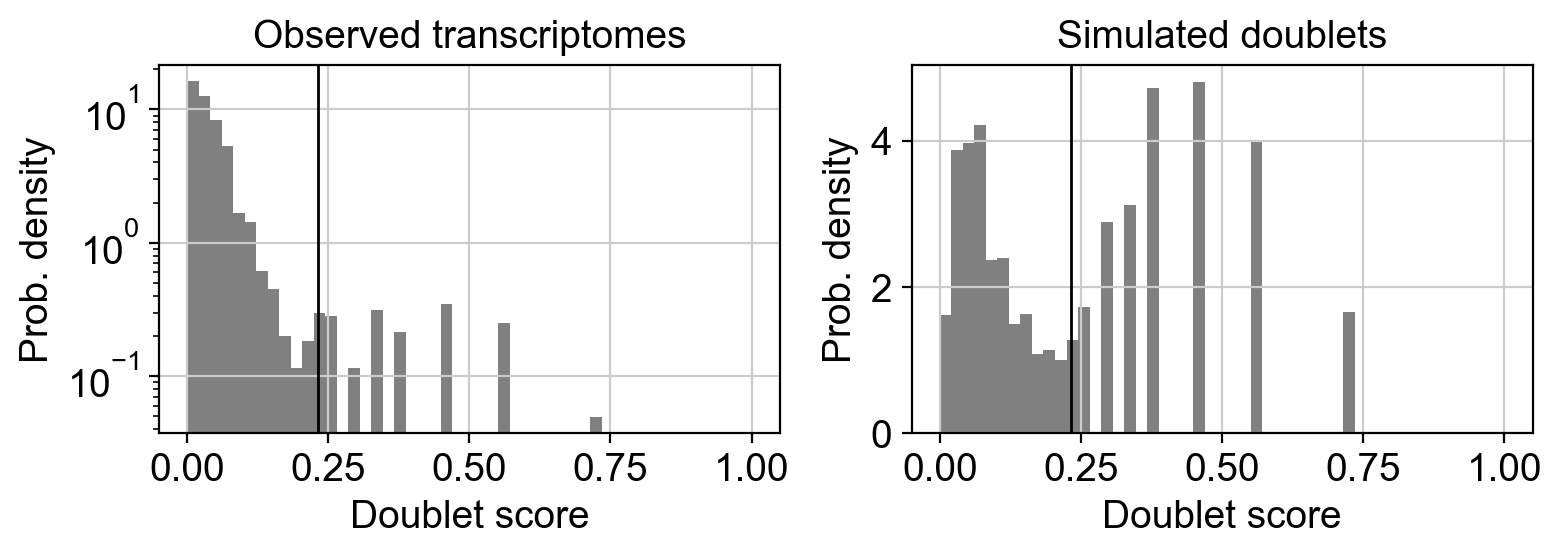

In [14]:
scrub.plot_histogram()

In [15]:
adata.write_h5ad(data_path + sample_ID + ".h5ad")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40


c:\Users\TLab\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


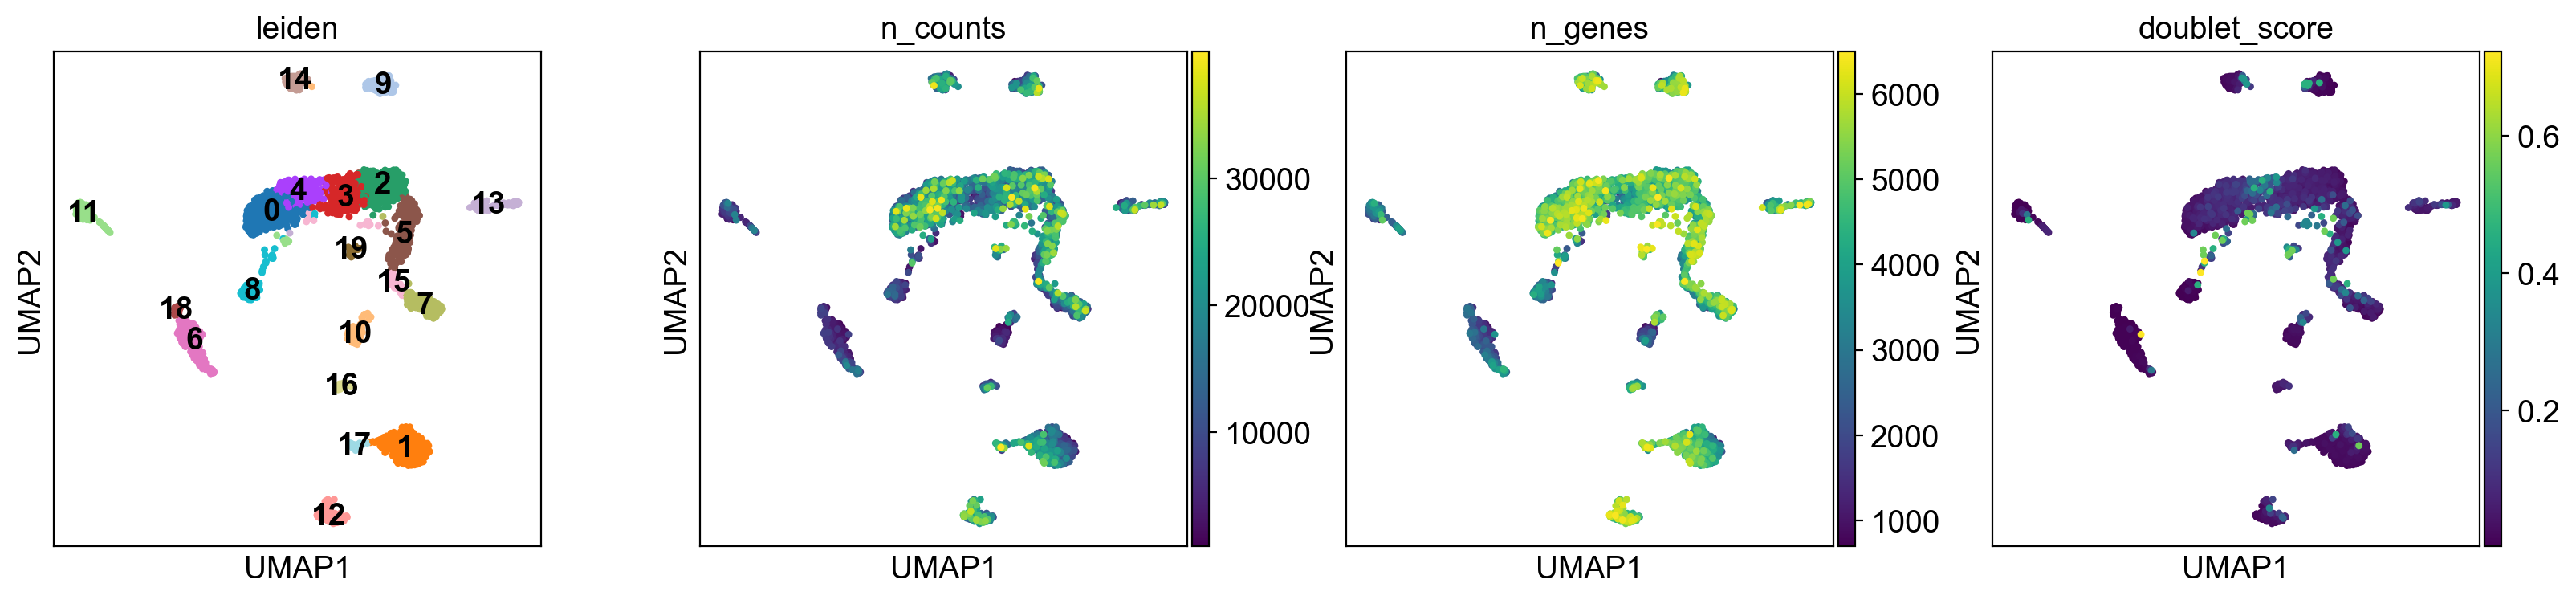

In [16]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "n_counts", "n_genes", "doublet_score"], legend_loc="on data")

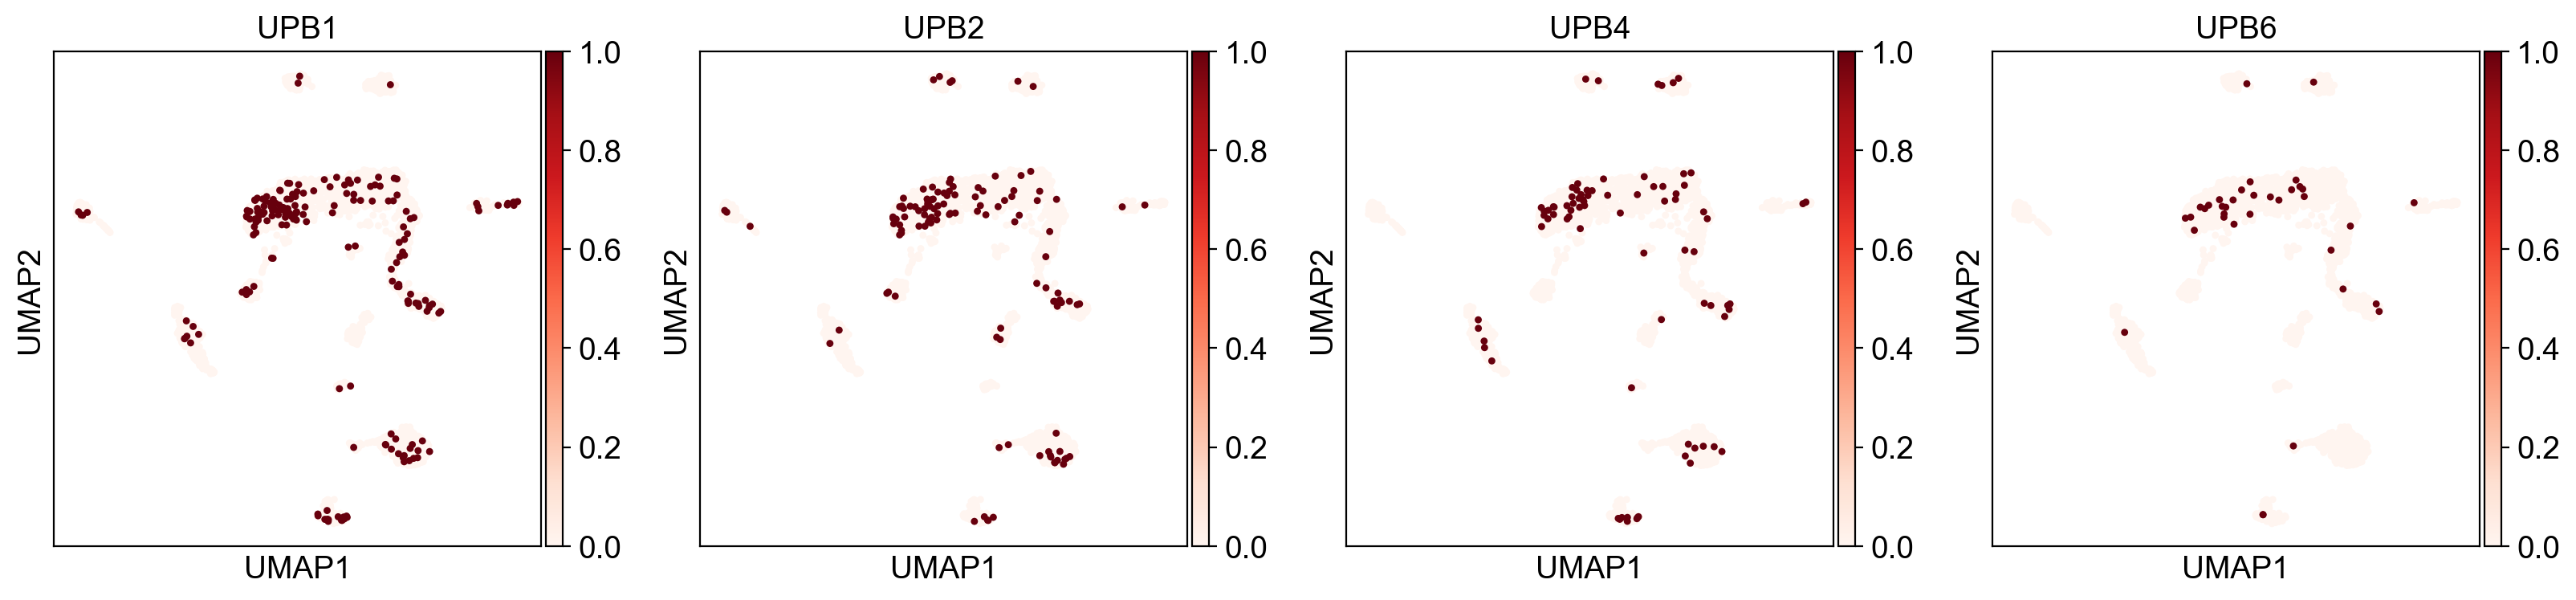

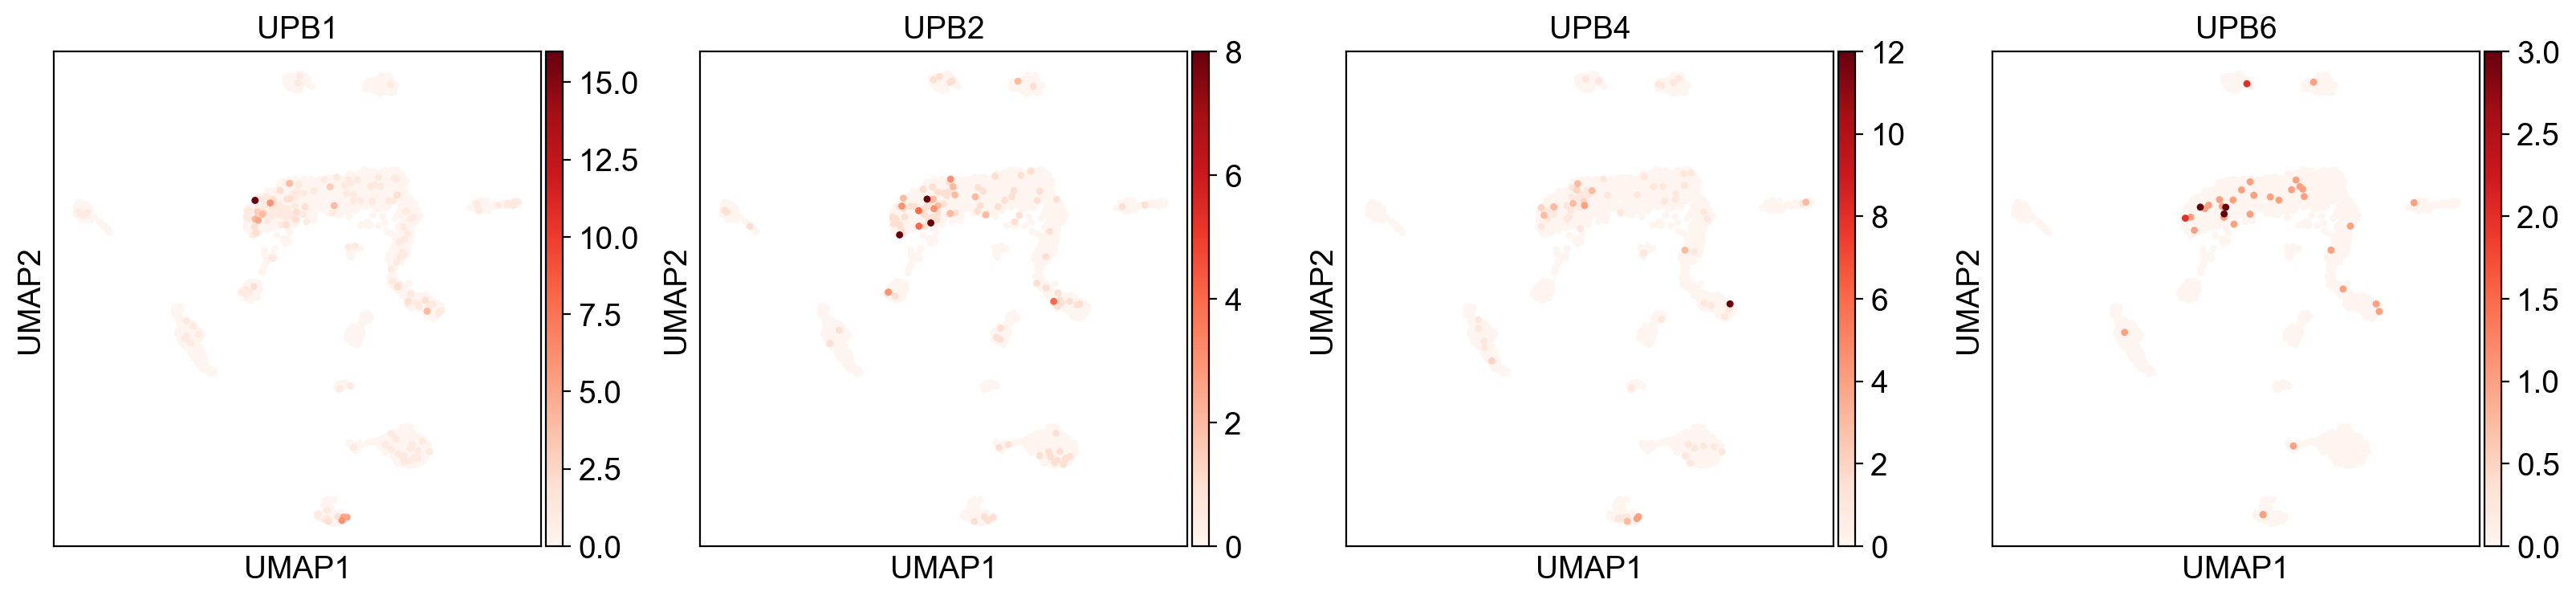

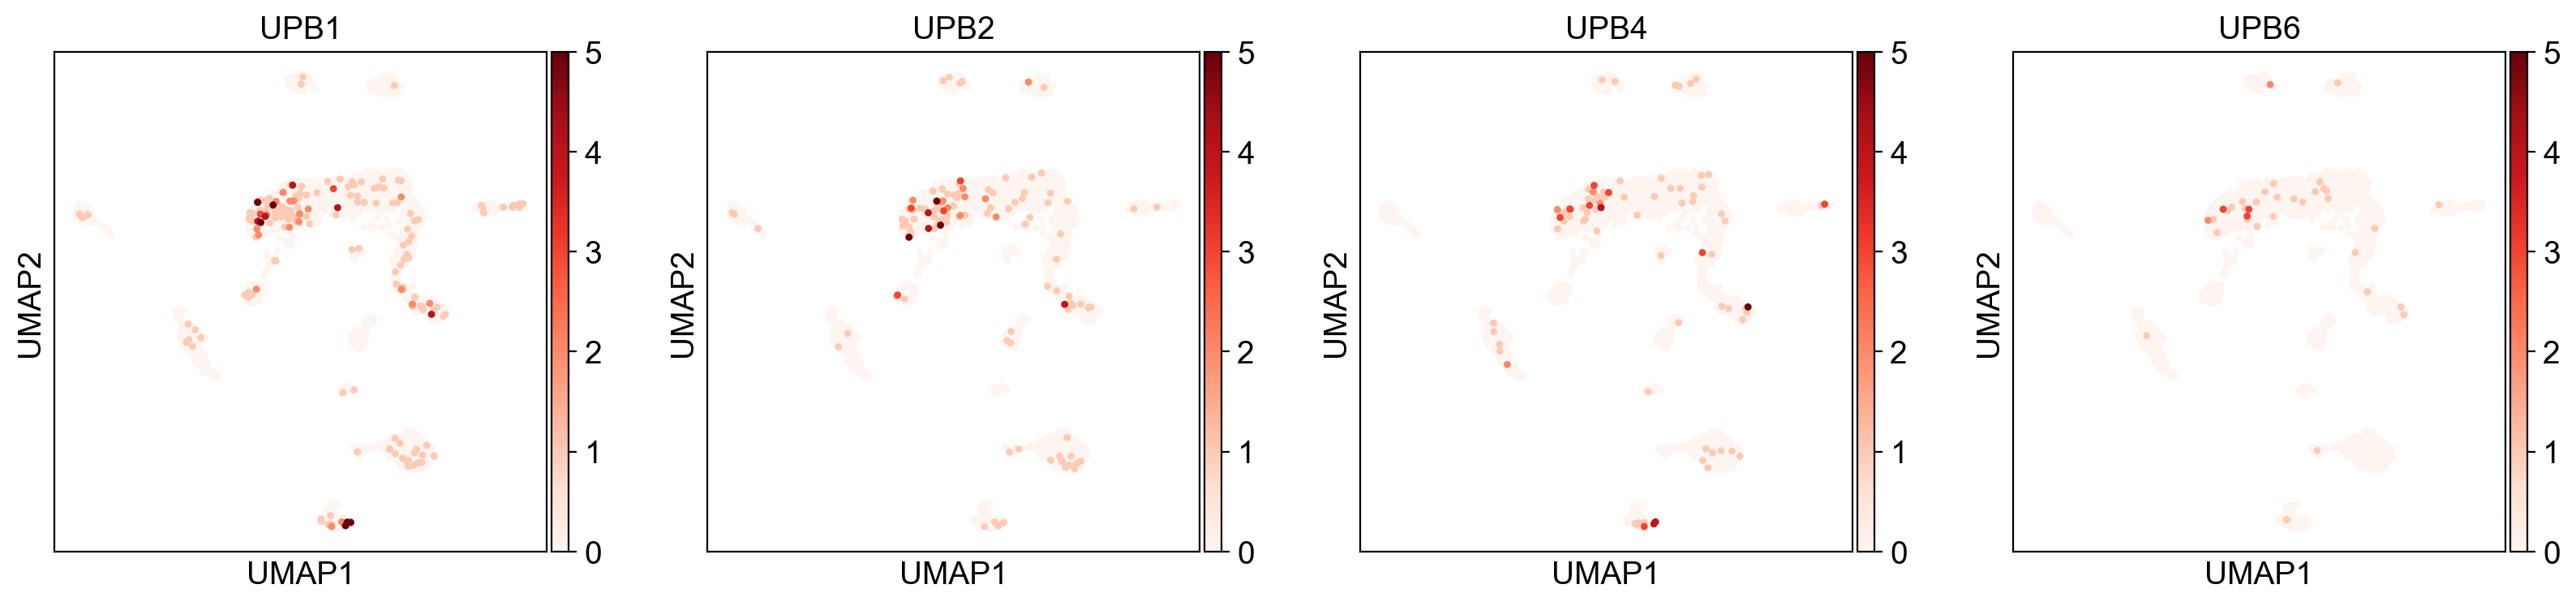

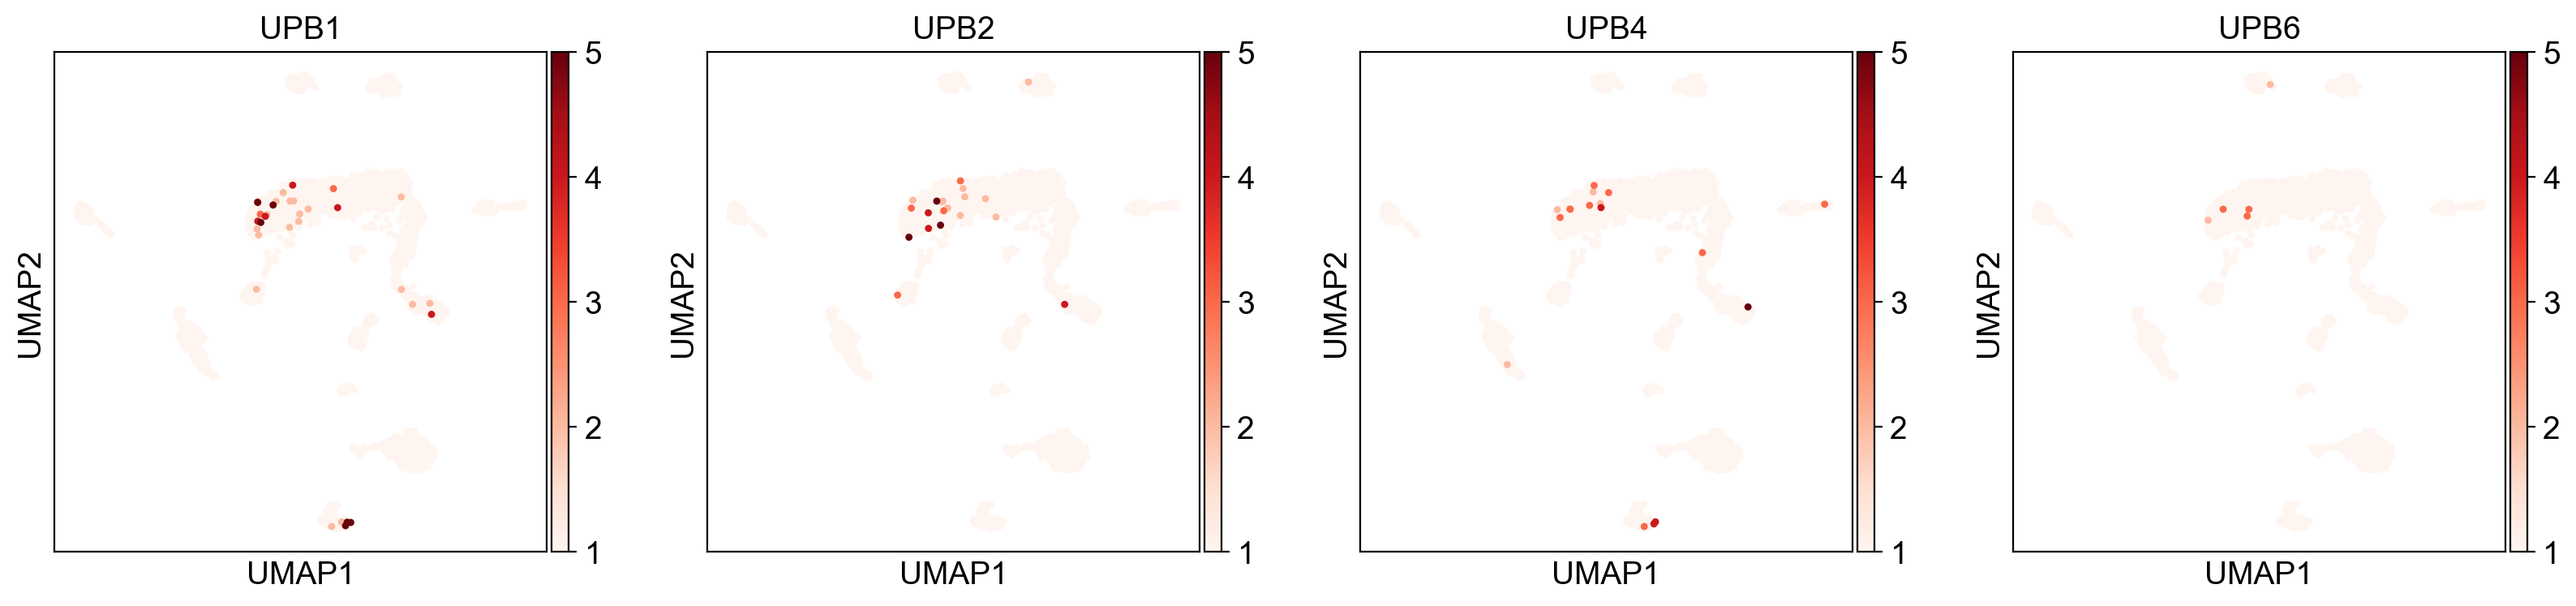

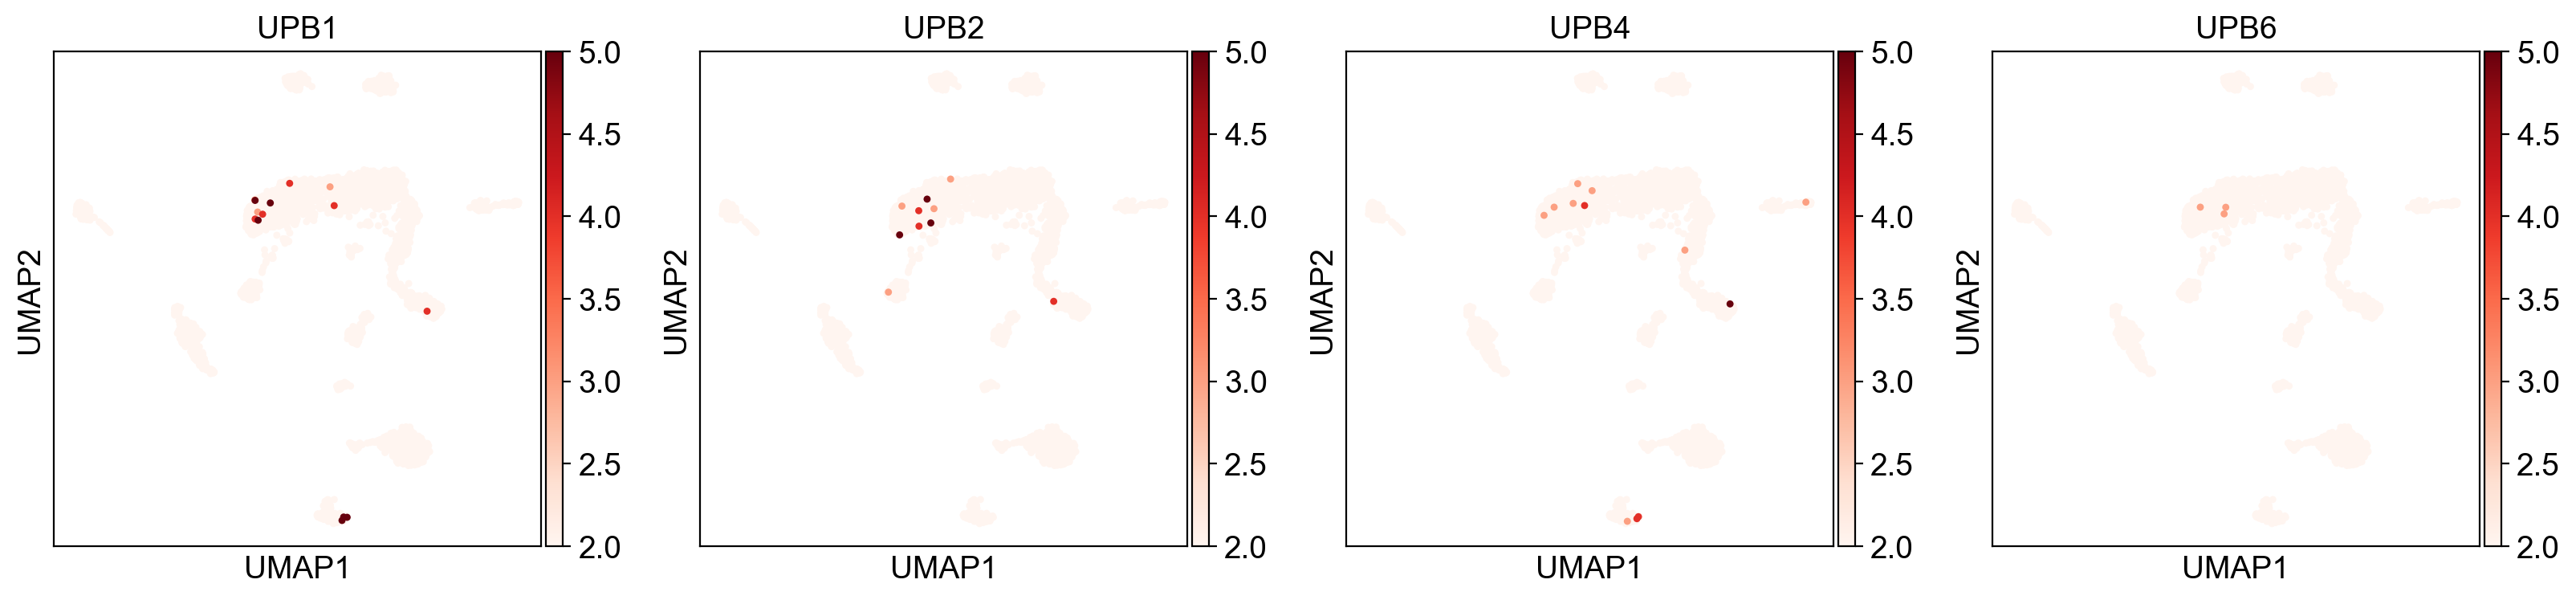

In [17]:
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmax=1)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds")
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmax=5)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmin=1, vmax=5)
sc.pl.umap(adata, color=["UPB1", "UPB2", "UPB4", "UPB6"], color_map="Reds", vmin=2, vmax=5)

C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Ryan\GitHub\scanpy\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


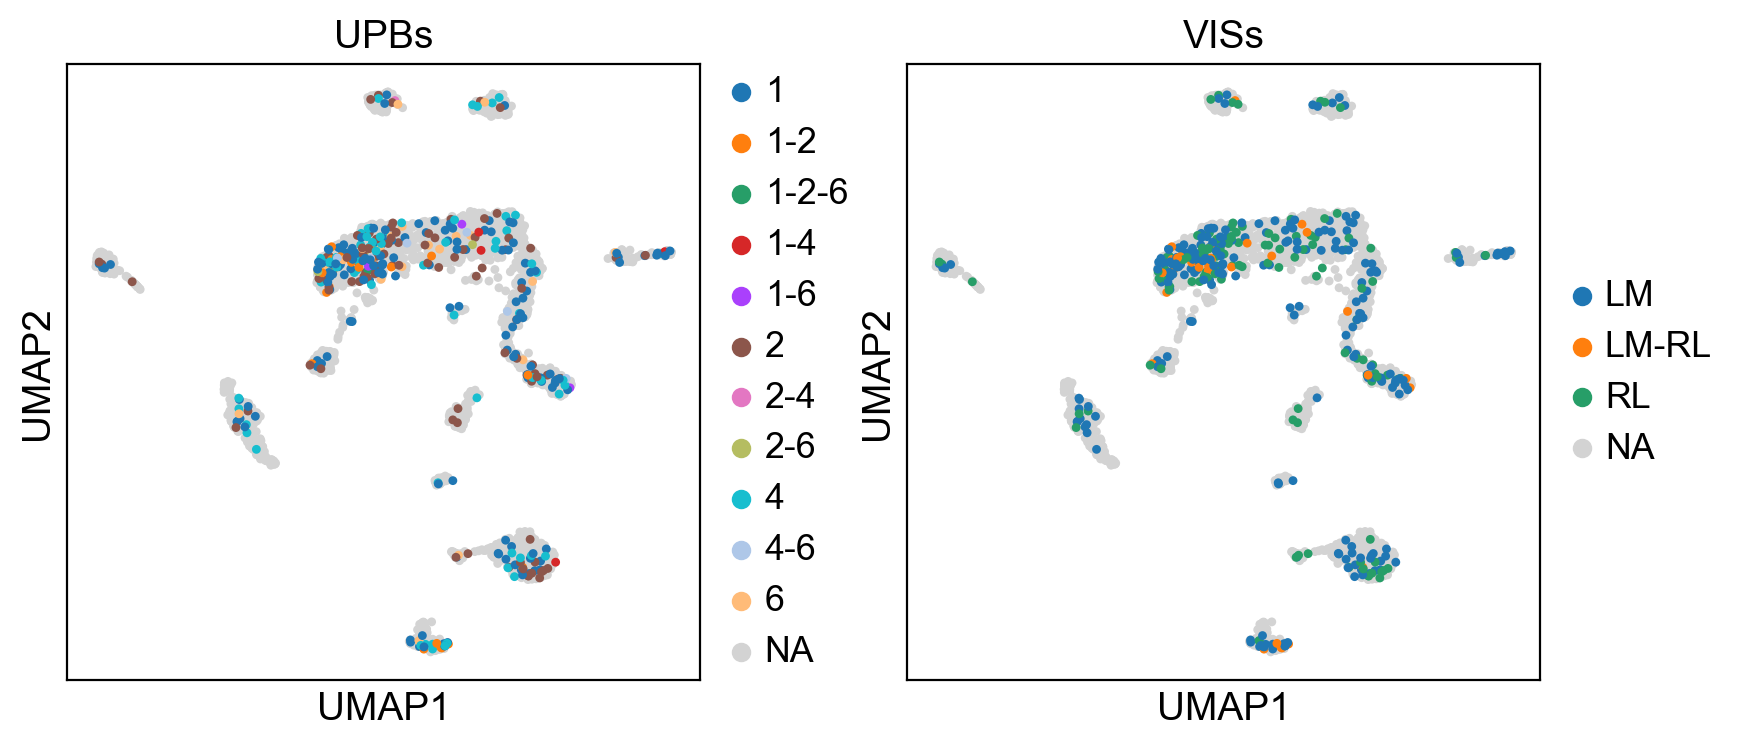

In [18]:
sc.pl.umap(adata, color=["UPBs", "VISs"])